In [4]:
import random
import torch
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import time

import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

In [6]:
SEED = 1038893

fix_random(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

root = "../../data/ml-25m"

Device: cuda


## Data Acquisition

In [7]:
def get_data_from_csv(file: str, nrows=None):
    if nrows:
        df = pd.read_csv(f"{root}/{file}", nrows=nrows)
    else:
        df = pd.read_csv(f"{root}/{file}")
    print(f"Loaded ml-25m data: {root}/{file}")

    return df

def get_ratings_from_csv(nrows=None):
    path = "ratings.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)

    data.drop("timestamp", axis=1, inplace=True)
    # todo: drop user id
    #data.drop("userId", axis=1, inplace=True)

    return data

def get_tag_relevances_from_csv(nrows=None):
    path = "genome-scores.csv"

    return get_data_from_csv(path, nrows)

In [8]:
genome_scores_path = "genome-scores.csv"
ratings_path = "ratings.csv"

In [9]:
ratings = get_ratings_from_csv()
print(ratings)

Loaded ml-25m data: ../../data/ml-25m/ratings.csv
          userId  movieId  rating
0              1      296     5.0
1              1      306     3.5
2              1      307     5.0
3              1      665     5.0
4              1      899     3.5
...          ...      ...     ...
25000090  162541    50872     4.5
25000091  162541    55768     2.5
25000092  162541    56176     2.0
25000093  162541    58559     4.0
25000094  162541    63876     5.0

[25000095 rows x 3 columns]


In [10]:
genome_scores = get_tag_relevances_from_csv()
print(genome_scores)

Loaded ml-25m data: ../../data/ml-25m/genome-scores.csv
          movieId  tagId  relevance
0               1      1    0.02875
1               1      2    0.02375
2               1      3    0.06250
3               1      4    0.07575
4               1      5    0.14075
...           ...    ...        ...
15584443   206499   1124    0.11000
15584444   206499   1125    0.04850
15584445   206499   1126    0.01325
15584446   206499   1127    0.14025
15584447   206499   1128    0.03350

[15584448 rows x 3 columns]


In [11]:
# films = get_data_from_csv(f"{root}/{ratings}")[]


In [14]:
class NeuralNetwork:
    def __init__(self, ratings, relevance, seed=1038893, batch_size=32, hidden_size1=64, hidden_size2=32, lr=0.001):
        # Pivot the relevance DataFrame to create a matrix of tag relevance scores for each movie
        relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)

        # Compute the mean rating for each user
        mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()

        # Merge the ratings and relevance data
        X = mean_ratings.merge(relevance_matrix, on='movieId')
        #X = addColumnOperation(ratings,X)
        X.columns = X.columns.astype(str)
        
        ratings = None
        X = X.sample(frac=1,random_state=seed).reset_index(drop=True)
        #X = X.drop('movieId', axis=1)
        y = X['rating']
        X = X.drop('movieId', axis=1)
        X = X.drop('rating', axis=1)
        self.train_loss_history = []
        self.val_loss_history = []
        
        # Split the data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        self.X_valid, self.X_test, self.y_valid, self.y_test = train_test_split(self.X_test, self.y_test, test_size=0.5, random_state=seed)

        self.X_test  = self.X_test.to_numpy()
        self.X_train = self.X_train.to_numpy()
        self.X_valid = self.X_valid.to_numpy()
            
        # Convert the data to PyTorch tensors
        self.X_train = torch.tensor(self.X_train, dtype=torch.float32)
        self.X_test = torch.tensor(self.X_test, dtype=torch.float32)
        self.X_valid = torch.tensor(self.X_valid, dtype=torch.float32)
        
        self.y_test = np.array(self.y_test)
        self.y_train = np.array(self.y_train)
        self.y_valid = np.array(self.y_valid)
        
        self.y_test = torch.tensor(self.y_test, dtype=torch.float32)
        self.y_train = torch.tensor(self.y_train, dtype=torch.float32)
        self.y_valid = torch.tensor(self.y_valid, dtype=torch.float32)
        
        # Define the neural network architecture
        self.model = nn.Sequential(
            nn.Linear(X.shape[1], hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, 1)
        )

        # Move the model to the GPU
        self.model = self.model.to(device)


        if torch.cuda.is_available():
            # Move the tensors to the GPU
            self.X_train = self.X_train.to(device)
            self.X_valid = self.X_valid.to(device)
            self.X_test = self.X_test.to(device)
            self.y_train = self.y_train.to(device)
            self.y_valid = self.y_valid.to(device)
            self.y_test = self.y_test.to(device)

        # Define the loss function and optimizer
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        self.batch_size = batch_size

    def train(self, num_epochs):
        # Iterate over the entire training dataset multiple times
        for epoch in range(num_epochs):
            start_time = time.time()
            # Set the model to training mode
            self.model.train()

            # Shuffle the training data
            indices = torch.randperm(len(self.X_train))
            shuffled_X = self.X_train[indices]
            shuffled_y = self.y_train[indices]

            # Divide the training data into batches
            for i in range(0, len(self.X_train), self.batch_size):
                # Zero the gradients
                self.optimizer.zero_grad()

                # Compute the forward pass
                batch_X = shuffled_X[i:i + self.batch_size]
                batch_y = shuffled_y[i:i + self.batch_size]
                #batch_X = self.X_train
                #batch_y = self.y_train
                
                outputs = self.model(batch_X)

                # Compute the loss
                loss = self.criterion(outputs.squeeze(), batch_y)

                # Compute the backward pass and update the weights
                loss.backward()
                self.optimizer.step()
                
            self.train_loss_history.append(loss)


            # Evaluate the model on the validation data
            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(self.X_test)
                val_loss = self.criterion(val_outputs.squeeze(), self.y_test)
                self.val_loss_history.append(val_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time
            # Print the training and validation loss
            #print(f'Epoch {epoch + 1}/{num_epochs} - eta: {elapsed_time:.2f}s -\tTrain Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    def test(self):
    # Set the model to evaluation mode
        self.model.eval()

        # Disable gradient calculation to speed up inference
        with torch.no_grad():
            # Compute the predictions for the test data
            y_pred = self.model(self.X_test).squeeze()

            # Compute the test loss
            test_loss = self.criterion(y_pred, self.y_test)

            # Compute the root mean squared error (RMSE) of the test predictions
            rmse = torch.sqrt(test_loss)

            # Compute the mean squared error (MSE) of the test predictions
            mse = test_loss.item()

            # Compute the mean absolute error (MAE) of the test predictions
            mae = nn.functional.l1_loss(y_pred, self.y_test).item()

            # Compute R^2 score of the test predictions
            ss_res = torch.sum(torch.square(y_pred - self.y_test))
            ss_tot = torch.sum(torch.square(self.y_test - torch.mean(self.y_test)))
            r2 = 1 - ss_res / ss_tot

            #Print the test metrics
            print(f"MSE: {mse} RMSE: {rmse} R2: {r2} MAE: {mae}")

        return  r2.item(), self.model
    
    def load(self,model):
        self.model = model

In [15]:

'''model = NeuralNetwork(ratings, 
                        genome_scores,
                        seed=1038893, 
                        batch_size=128, 
                        hidden_size1=64, 
                        hidden_size2=64, 
                        lr=0.0005)


model.train(100)
model.test()'''


'model = NeuralNetwork(ratings, \n                        genome_scores,\n                        seed=1038893, \n                        batch_size=128, \n                        hidden_size1=64, \n                        hidden_size2=64, \n                        lr=0.0005)\n\n\nmodel.train(100)\nmodel.test()'

In [16]:
import itertools

batchsize = [1024]	
hidden_size1 = [256]
hidden_size2 = [256]
lr = [0.01]
num_epochs = [400]


best_model_params = None 
best_r2 = 0

total_iterations = len(batchsize) * len(hidden_size1) * len(hidden_size2) * len(lr) * len(num_epochs)
current_iteration = 0


for batchsize,hidden_size1,hidden_size2,lr,num_epochs in itertools.product(batchsize,hidden_size1,hidden_size2,lr,num_epochs):
    current_iteration += 1
    print(f'[{current_iteration}/{total_iterations}] START => batchsize: {batchsize}, hidden_size1: {hidden_size1}, hidden_size2: {hidden_size2}, lr: {lr}, num_epochs: {num_epochs}')
    model = NeuralNetwork(ratings, 
                        genome_scores,
                        seed=1038893, 
                        batch_size=batchsize, 
                        hidden_size1=hidden_size1, 
                        hidden_size2=hidden_size2, 
                        lr=lr)
    
    
    model.train(num_epochs)
    r2, model_instance  = model.test()
    print(f'DONE: {r2} => batchsize: {batchsize}, hidden_size1: {hidden_size1}, hidden_size2: {hidden_size2}, lr: {lr}, num_epochs: {num_epochs}')
    
    #Se lo voglio caricare uso torch.load('modello.pt')
    if r2 > best_r2:
        best_r2 = r2
        best_model_params = f'{batchsize}_{hidden_size1}_{hidden_size2}_{lr}_{num_epochs}'
        #torch.save(model_instance, f'model\model_{batchsize}_{hidden_size1}_{hidden_size2}_{lr}_{num_epochs}.pt')
        print(f'New best model: {best_model_params}')
    
print('============================================================')
#model = NeuralNetwork(ratings,genome_scores)
#print(f'Best model SCORE: {best_r2}')
#model.load(torch.load(f'model/model_{best_model_params}.pt'));
#print(model.test())

[1/1] START => batchsize: 1024, hidden_size1: 256, hidden_size2: 256, lr: 0.01, num_epochs: 400
MSE: 0.006640116684138775 RMSE: 0.08148691058158875 R2: 0.9723891019821167 MAE: 0.0629449188709259
DONE: 0.9723891019821167 => batchsize: 1024, hidden_size1: 256, hidden_size2: 256, lr: 0.01, num_epochs: 400
New best model: 1024_256_256_0.01_400


In [17]:
cuda_train_loss_history = model.train_loss_history
cuda_val_loss_history = model.val_loss_history

In [18]:
train_loss_history = []
for item in cuda_train_loss_history:
    blbl = item.cpu()
    train_loss_history.append(item.cpu().detach().numpy())

val_loss_history = []
for item in cuda_val_loss_history:
    val_loss_history.append(item.cpu().detach().numpy())


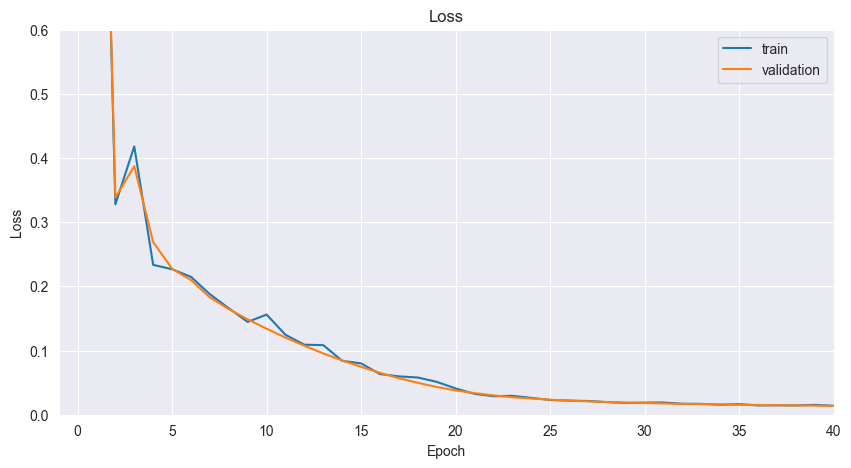

In [25]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,5))
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='validation')
plt.ylim(0,.6)
plt.xlim(-1,40)

plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()